# CSCA 5642 Introduction to Deep Learning Week 6 Final Project

**Project topic**: This project intends to help the learner gain further natural language processing (NLP) technique. NLP is a branch of artificial intelligence (AI) and computational linguistics that focuses on enabling computers to understand, interpret, and generate human language in a way that is both meaningful and useful. NLP involves many sub-domains such as text understanding, text generation, language modeling, etc. The primary task of this project - text classification - is generally considered to be under the umbrella of text understanding. Other common tasks in text understanding include named entity recognition, sentiment analysis, and semantic parsing.

## Data collection and provenance of the data

Data source: vinodkumar (2019), healthcare ticketing system, from https://www.kaggle.com/datasets/vinodkumarcvk/healthcareticketingsystem/data

Data collection method: the data is directly downloaded from Kaggle to local environment.

Data provenance: The dataset consists of two columns: one is text (the "converse" column) and the other is the category of the text ("categories"). The data came from the phone call notes from a healthcare provider called "Life Line Health Services". This provider uses a ticketing system for the telephone calls it receives across all the departments. The staff members that receive the call write the summary ("converse") without standardized guidelines.

## Identify a deep learning problem

The *data provenance* section above describes the creation of a ticket. Naturally the next step is that staff members manually categorize the tickets, so the tickets can be routed to the correct department and eventually the patient requests can be fulfilled. Calls can be for New Appointment, Cancellation, Medical Refills, and other categories. In this dataset, each ticket is associated to only one category. 

In this project we will use machine learning technique to automatically categorize the tickets. 

With the presence of the "categories" column in the training dataset, this is a typical supervised learning task. We will use multi-class text classification to achieve the categorization. Multiple algorithms will be used to build text classification models: multi-layer perceptron, RNN, and CNN. 

The **importance** of this project lies in this automated categorization, which can potentially save cost and increase productivity for the healthcare provider compared to manually categorizing the tickets. 

## Preparation

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
# from itertools import islice
import random

# text pre-processing
import nltk # natural language processing
from nltk.corpus import stopwords, wordnet # stop words
# from nltk.stem.snowball import SnowballStemmer # stemming
from nltk import pos_tag, word_tokenize # identify POS tag, required by lemmatizer
from nltk.stem import WordNetLemmatizer # lemmatization

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import layers, models, regularizers

from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner as kt

# fix random seed for reproducibility
SEED = 0
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

2024-02-29 20:02:02.271699: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 20:02:02.304940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
project_root = '/home/lee/Documents/CSCA5642/week6/'
data_folder = os.path.join(project_root, 'data')

In [4]:
train_orig = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_orig = pd.read_csv(os.path.join(data_folder, 'test.csv'))

## Description of data

### Size

In [4]:
print("Training data information:")
print(train_orig.info())
print(f'training data size {train_orig.size}')
print('\n')

print("Test data information:")
print(test_orig.info())
print(f'test data size {test_orig.size}')

Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48699 entries, 0 to 48698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categories  48699 non-null  object
 1   converse    48667 non-null  object
dtypes: object(2)
memory usage: 761.1+ KB
None
training data size 97398


Test data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8581 entries, 0 to 8580
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   converse  8577 non-null   object
dtypes: object(1)
memory usage: 67.2+ KB
None
test data size 8581


### Dimension

In [5]:
print(f"Training data number of samples: {train_orig.shape[0]}")
print(f"Training data number of columns: {train_orig.shape[1]}")
print('\n')
print(f"Test data number of records: {test_orig.shape[0]}")
print(f"Test data number of columns: {test_orig.shape[1]}")

Training data number of samples: 48699
Training data number of columns: 2


Test data number of records: 8581
Test data number of columns: 1


### Structure

In [6]:
print(f'Training data structure: \n{train_orig.head()}')
print('\n')
print(f'Test data structure: \n{test_orig.head()}')

Training data structure: 
              categories                                           converse
0  QUERIES FROM PHARMACY  please to verify instructions for drugname pat...
1        NEW APPOINTMENT  lmovm for patients mother to and schd rov trac...
2                 OTHERS  labtype and insurance approval other incoming ...
3                 OTHERS  clinical list changes medfusion secure electro...
4     MEDICATION RELATED  wants to wean off medication work phone name d...


Test data structure: 
                                            converse
0  request to speak with rn no given patients ref...
1  patients husband ret name spouse for other pat...
2  fyi in his szs mom other he has an appointment...
3  Rx refill drugname from pharmacy name reason f...
4  need more time for testing dad is requesting a...


## Analysis plan

At a high level, we will first clean the text data; we will then fit multiple models of different deep learning algorithms to perform the text classification task. We will compare their performances and then tune the hyperparameters of the selected model.

## Exploratory Data Analysis (EDA)

### Inspect data

In [51]:
print('Distribution of labels in training data:')
print(train_orig['categories'].value_counts())
print('\n')
print(f"Number of unique labels: {train_orig['categories'].nunique()}")

Distribution of labels in training data:
categories
MEDICATION RELATED                               9010
NEW APPOINTMENT                                  8907
REFILL                                           8347
OTHERS                                           6232
SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)    3018
LAB RESULTS                                      2253
PROVIDER                                         1677
QUERIES FROM PHARMACY                            1464
RESCHEDULING                                     1382
SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)       1212
PRIOR AUTHORIZATION                              1043
SYMPTOMS                                         1021
CHANGE OF PROVIDER                                811
RUNNING LATE TO APPOINTMENT                       590
CANCELLATION                                      563
QUERY ON CURRENT APPOINTMENT                      559
FOLLOW UP ON PREVIOUS REQUEST                     304
CHANGE OF HOSPITAL            

#### Handle missing data

In [8]:
print(f'number of missing values in the converse column: {train_orig["converse"].isna().sum()}')
print(f'number of missing values in the categories column: {train_orig["categories"].isna().sum()}')

number of missing values in the converse column: 32
number of missing values in the categories column: 0


Remove the rows where the text is null

In [5]:
train_orig = train_orig[train_orig['converse'].notna()]

### Visualize data

#### Word count

Distribution of word counts
count    48667.000000
mean        82.034644
std         52.495108
min          1.000000
25%         39.000000
50%         74.000000
75%        120.000000
max        463.000000
Name: converse, dtype: float64


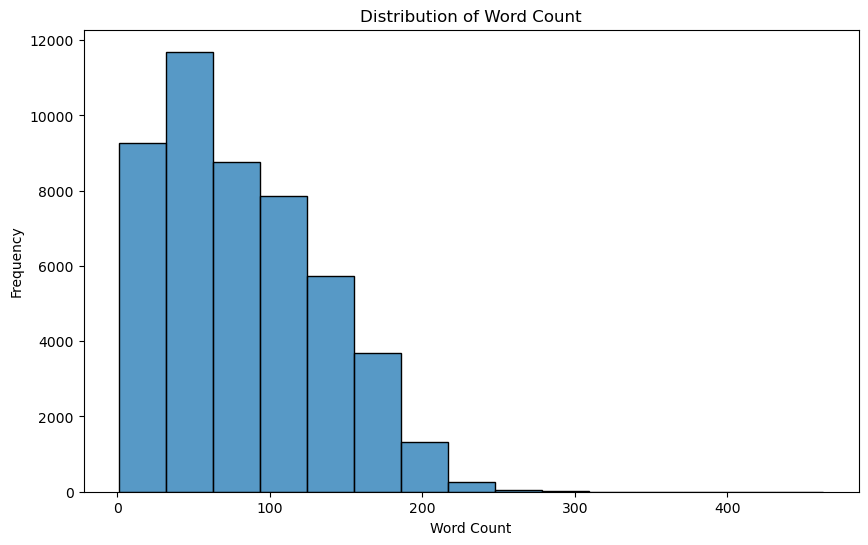

In [8]:
word_counts = train_orig['converse'].str.split().str.len()
print('Distribution of word counts')
print(word_counts.describe())
plt.figure(figsize=(10, 6))
# Plot a histogram of the distribution of word count
sns.histplot(word_counts, bins=15)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
# plt.grid(True)
plt.show()

### Determine data transformation

When inspecting samples from the training dataset, we notice that
* the text contains very common English words like "an"
* most of the text is lower case but not 100%
* the data contains misspellings

We will apply some data cleaning techniques to solve the first two problems. 

Tickets have 21 categories. We will transform the 21 levels of the target into one-vs-all binary labels. One example of this one-vs-all manner is: supposing we have a dataset with a field with 4 levels: a, b, c, d, then a sample with "a" will be transformed into [1, 0, 0, 0], "b" -> [0, 1, 0, 0], "c" -> [0, 0, 1, 0], and "d" -> [0, 0, 0, 1].

### Clean data

Here we will clean the text data. 

**Removing punctuation** and converting all text to **lowercase** are self-explanatory. 

Stop words are a set of commonly used words in a language. Examples of stop words in English are "a", "the", "is", "are", etc. These words are so widely used that they carry very little useful information. Hence we **remove stop words** to reduce the number of tokens our algorithms need to process. 

These steps eliminate unnecessary symbols or words and make text more clean.

**Lemmatization** refers breaking a word down to its root meaning to identify similarities. Converting the word "better" to its root word "good", and "taken" -> "take", are both examples of lemmatization. 

This transformation normalizes different inflected forms of a word so that they can be analyzed or compared more easily. 

**Tokenization** is the process of converting the text sequence in the "converse" field into smaller parts known as tokens - tokens are often words. 

The reason to perform tokenization is that it reduces the per-unit size of raw text, so that the text can be handled more easily for processing and analysis in subsequent steps. Without tokenization, each unit is one entire phone call summary; after tokenization, one unit of analysis is one word in our case. 

In [11]:
# download to working directory
nltk_download_dir = os.path.join(project_root, 'nltk_downloads')
nltk.download(['stopwords', 'wordnet', 'punkt', 'averaged_perceptron_tagger'], download_dir=nltk_download_dir)
nltk.data.path.append(nltk_download_dir)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lee/Documents/CSCA5642/week6/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lee/Documents/CSCA5642/week6/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/lee/Documents/CSCA5642/week6/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lee/Documents/CSCA5642/week6/...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# remove punctuation
train_orig['removepunc'] = train_orig['converse'].str.replace('[^\w\s]', ' ')

# lower casing
train_orig['lower'] = train_orig['removepunc'].str.lower()

# tokenize and lemmatize
# adjective, adverb, noun, verb = 'JJ', 'RB', 'NN', 'VB'
map_pos = {'NN': 'n', 'JJ': 'a', 'RB': 'r', 'VB': 'v'}

def lemmatize_after_pos(review):
    lemma_review = []
    for word, tag in pos_tag(word_tokenize(review)):
        wntag = tag[0:2]
        wntag = map_pos[wntag] if wntag in set(map_pos.keys()) else None
        lemma = WordNetLemmatizer().lemmatize(word, wntag) if wntag else word
        lemma_review.append(lemma)
    return lemma_review

train_orig['lemmatized'] = train_orig['lower'].apply(lambda x: lemmatize_after_pos(x))

# remove stopwords
stop = stopwords.words('english')
train_orig['removestop'] = train_orig['lemmatized'].apply(lambda x: [item for item in x if item not in stop])

train_orig['processed_converse'] = train_orig['removestop'].apply(lambda x: ' '.join(x))

### Most frequent words

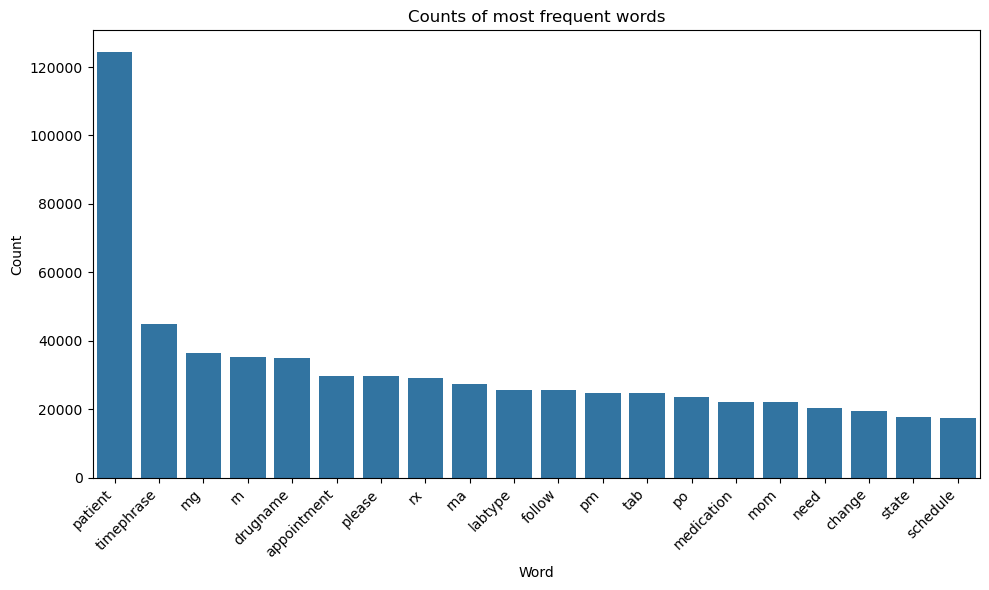

In [13]:
word_freq = Counter(" ".join(train_orig['processed_converse'].values.tolist()).split(" "))

df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Count', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Counts of most frequent words')
plt.tight_layout()
plt.show()

del df

### Split training and testing datasets

In [14]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(train_orig['processed_converse'], \
                                                                train_orig["categories"], \
                                                                test_size=0.2, random_state=0)

#### Tokenize, truncate/pad the conversations

In [15]:
hparams = {
    "batch_size": 32,
    "epochs": 16,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 32,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 768
}

num_classes = df_y_train.nunique()

In [16]:
tokenizer = Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(df_X_train)

def prep_text(texts, tokenizer, max_sequence_length):
    """Turns text into into padded sequences
    """
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

X_train = prep_text(df_X_train, tokenizer, hparams["max_sequence_length"])
X_test = prep_text(df_X_test, tokenizer, hparams["max_sequence_length"])

#### Transform the labels

In [17]:
encoder = LabelBinarizer()
encoder.fit(df_y_train)
y_train = encoder.transform(df_y_train)
y_test = encoder.transform(df_y_test)

#### The mapping between actual topics and their encoded representation

In [18]:
# key is textual topics, value is numerical matrix
y_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

## Model development

### Helper functions

In [54]:
def summarize_history(model_history):
    sns.lineplot(model_history.history['accuracy'], color='blue').set_title('model accuracy')
    sns.lineplot(model_history.history['val_accuracy'], color='green')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

def generate_prediction(model, transformed_test_data, encoder=encoder):
    predicted_label = encoder.inverse_transform(model.predict(transformed_test_data))
#     prediction = model.predict(test_data, batch_size=hparams["batch_size"])
#     predicted_label = encoder.classes_[np.argmax(prediction, axis=1)]

    return predicted_label

def plot_confusion_matrix(model, transformed_test_data, test_target, encoder=encoder):

    predicted_label = generate_prediction(model, transformed_test_data, encoder)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_target, predicted_label)
    # normalize confusion matrix as classes are not balanced
    cnf_matrix_normalized = cnf_matrix/cnf_matrix.sum(axis=1)[:, np.newaxis]
    # heatmap 
    plt.figure(figsize = (10, 8))
    sns.heatmap(cnf_matrix_normalized, cmap="GnBu", linewidths=0.1, linecolor='gray', \
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)

    plt.ylabel('True category', fontsize=15)
    plt.xlabel('Predicted category', fontsize=15)

    plt.title("Normalized Confusion Matrix", fontsize=20)

# Look at a few predictions that the prediction was wrong
def concat_prediction(model, test_data, transformed_test_data, test_target, encoder=encoder, num=5):

    predicted_label = generate_prediction(model, transformed_test_data, encoder)
    df_diff_model = df_y_test[test_target != predicted_label]
    df_y_compare = pd.concat([test_target, pd.Series(predicted_label, index=test_target.index)], axis=1)

    for i in list(df_diff_model.index[:num]):
        print(i)
        print(test_data.loc[i])
        print(f'Actual label: {test_target.loc[i]}')
        print(f"Predicted label: {df_y_compare[0].loc[i]}")
        print("\n")    

### Multi-layer perceptron neural network model

A Multi-Layer Perceptron (MLP) is a type of artificial neural network that consists of multiple layers of nodes, or neurons. A MLP model typically has one input layer, one or more hidden layers, and one output layer. The general approach of an MLP neural network model involves several key steps: weight initialization, forward propagation, loss calculation, back propagation, optimization, iterative training.

After iterative training, the model has learned its weights and biases from the training data. The rest of the model development process is the same as conventional machine learning models: performance evaluation and prediction.

**Reason for using this architecture**: MLP models can learn complex mappings from input features to output labels without relying on predefined assumptions about the data distribution. They are able to capture non-linear relationships in the data, allowing them to learn complex patterns and representations from text data. They can also serve as building blocks in more complex deep learning architectures for NLP, such as sequence-to-sequence models, attention mechanisms, and transformer models. They can be integrated as part of the encoder or decoder components to process input or generate output representations in these architectures.

#### Build model

In [20]:
model_mlp = models.Sequential()

model_mlp.add(layers.Embedding(hparams["max_num_words"], hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))
model_mlp.add(layers.Flatten())
model_mlp.add(layers.Dense(512, input_shape=(hparams["max_num_words"],), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_mlp.add(layers.Dropout(0.5))
model_mlp.add(layers.Dense(num_classes, activation='softmax'))
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-02-26 21:30:11.081900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 21:30:11.097783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 21:30:11.097886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Model comparsion

### RNN LSTM

Next we fit a Long Short-Term Memory (LSTM) neural network model.

Recurrent Neural Networks (RNNs) are commonly used in natural language processing tasks. RNNs are designed to handle sequential data by maintaining a hidden state that captures information about previous inputs in the sequence. They process input data step by step, updating their hidden state at each time step based on the current input and the previous hidden state. However, traditional RNNs suffer from the vanishing gradient problem, where gradients diminish as they are backpropagated through time, making it difficult for the network to learn long-range dependencies. This is why we use a LSTM model instead of vanilla RNN. LSTMs are a type of RNN specifically designed to address the vanishing gradient problem and capture long-range dependencies more effectively.

**Reason for using this architecture**: RNN models are designed to handle sequential data, making them well-suited for tasks that involve processing and understanding sequences of words or characters. RNN models can handle variable-length inputs, which is common in NLP tasks where the length of input sequences (e.g., sentences, documents) varies. RNN models are effective at capturing recurrent patterns and repetitive structures in sequential data. RNN models can produce contextual embeddings for words or sentences by considering their context within a sequence. These contextual embeddings capture the meaning and semantics of words in different contexts.

#### Build model

In [21]:
model_rnn = models.Sequential()
model_rnn.add(layers.Embedding(hparams["max_num_words"], hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))
model_rnn.add(layers.LSTM(64))
model_rnn.add(layers.Dense(num_classes, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### CNN

Convolutional Neural Networks (CNNs) are a type of deep learning model commonly used for image-related tasks. However, they are also suitable for natural language processing tasks. 

The core building blocks of CNNs are convolutional layers. These layers help extract hierarchical representations of the input data. Another type of layer that is often used in CNNs is pooling layer; they reduce the spatial dimensions (width and height) of feature maps.

**Reason for choosing this architecture**: CNNs are able to capture local patterns in the input text through the use of convolutional filters. CNNs can learn hierarchical representations of features. In NLP, this allows them to capture complex relationships between words and phrases at different levels of abstraction. CNNs are efficient when handling fixed-length sequences; in general we would find this characteristic a disadvantage compared to RNN, as in most NLP use cases one would expect variable-length inputs. However, in this project I pad/truncate the input text to the same length, making CNN applicable. 

#### Build model

In [22]:
# create the model
model_cnn = models.Sequential()

model_cnn.add(layers.Embedding(hparams["max_num_words"], hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))

model_cnn.add(layers.Conv1D(activation="relu", filters=32, kernel_size=3, padding="same"))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Dropout(0.5)) # dropout after pooling
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(num_classes, activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Hyperparameter tuning

I will perform hyperparameter tuning in the winning model. Refer to the Results and analysis section for the hyperparameter optimization process.

## Results and analysis

### MLP

#### Train model

In [23]:
history_mlp = model_mlp.fit(X_train, y_train,
                    batch_size=hparams["batch_size"],
                    epochs=hparams["epochs"],
                    verbose=1,
                    validation_split=0.1)
score_mlp = model_mlp.evaluate(X_test, y_test,
                       batch_size=hparams["batch_size"], verbose=1)
print('Test score:', score_mlp[0])
print('Test accuracy:', score_mlp[1])

Epoch 1/16


2024-02-26 21:30:12.028683: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4d8d549610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 21:30:12.028702: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-02-26 21:30:12.030888: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-26 21:30:12.037188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-26 21:30:12.042167: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
 

1095/1095 [==============================] - 22s 20ms/step - loss: 2.0921 - accuracy: 0.5144 - val_loss: 1.8144 - val_accuracy: 0.5855
Epoch 2/16
1095/1095 [==============================] - 6s 5ms/step - loss: 1.7642 - accuracy: 0.6256 - val_loss: 1.7600 - val_accuracy: 0.6204
Epoch 3/16
1095/1095 [==============================] - 5s 4ms/step - loss: 1.7117 - accuracy: 0.6595 - val_loss: 1.7447 - val_accuracy: 0.6433
Epoch 4/16
1095/1095 [==============================] - 4s 4ms/step - loss: 1.6715 - accuracy: 0.6819 - val_loss: 1.7211 - val_accuracy: 0.6551
Epoch 5/16
1095/1095 [==============================] - 4s 4ms/step - loss: 1.6615 - accuracy: 0.6980 - val_loss: 1.8170 - val_accuracy: 0.6510
Epoch 6/16
1095/1095 [==============================] - 4s 3ms/step - loss: 1.6471 - accuracy: 0.7095 - val_loss: 1.8883 - val_accuracy: 0.6513
Epoch 7/16
1095/1095 [==============================] - 4s 4ms/step - loss: 1.6418 - accuracy: 0.7244 - val_loss: 1.8966 - val_accuracy: 0.6523
E

#### Visualize training history

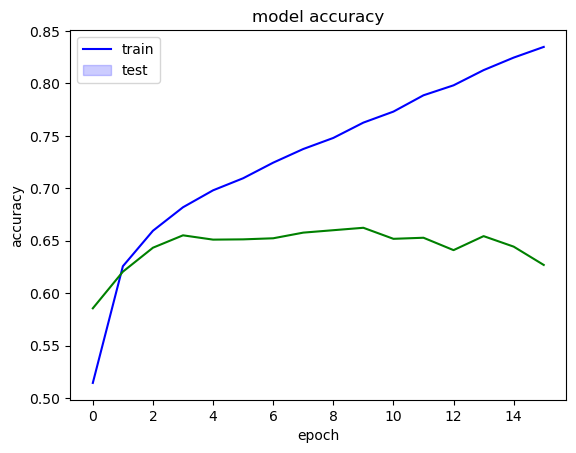

In [24]:
summarize_history(history_mlp)

#### Plot confusion matrix

305/305 [==============================] - 0s 410us/step


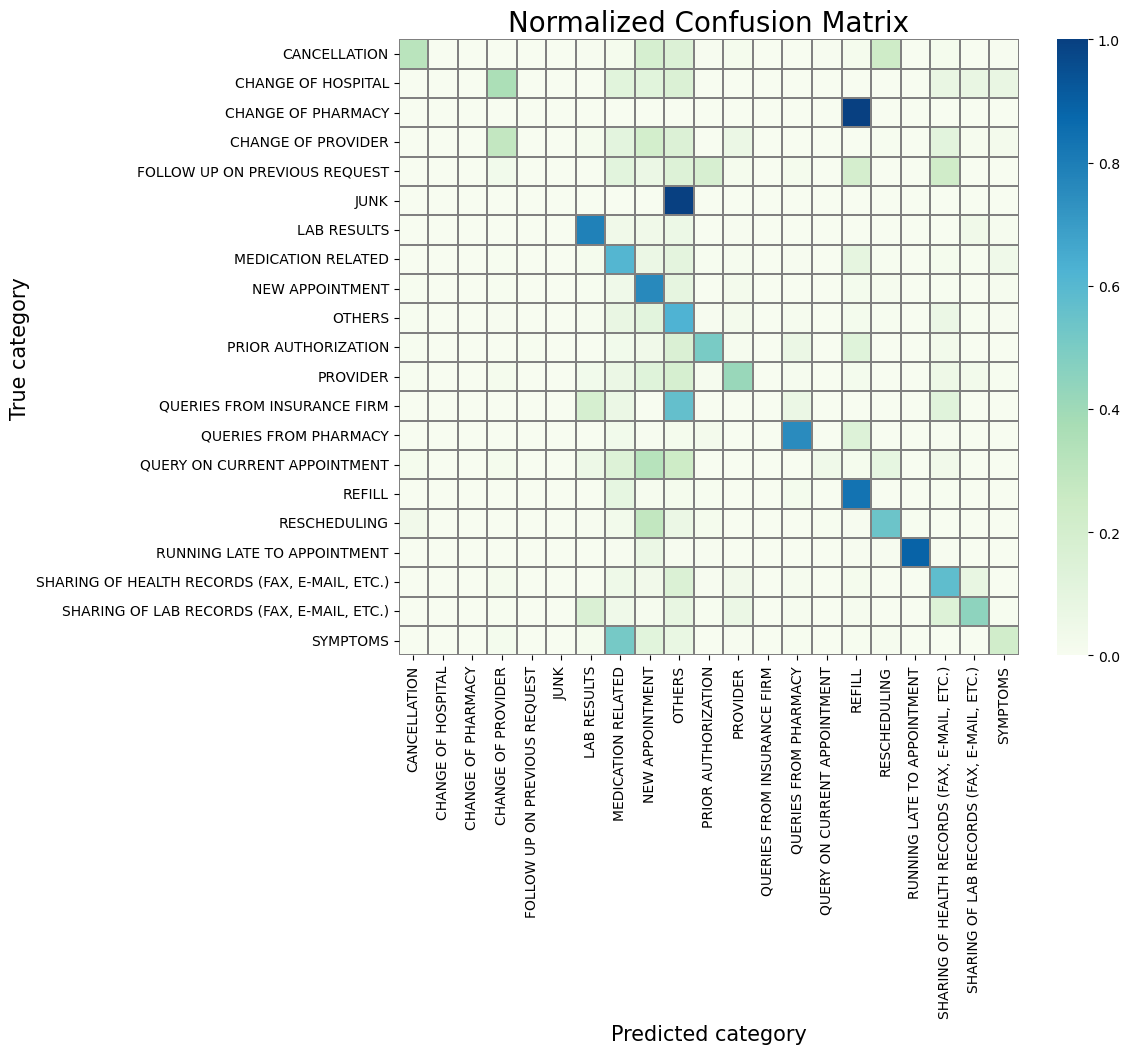

In [25]:
plot_confusion_matrix(model_mlp, transformed_test_data=X_test, test_target=df_y_test)

#### Inspect wrong predictions

In [55]:
print("Look at a few wrong predictions:")
concat_prediction(model_mlp, test_data=df_X_test, transformed_test_data=X_test, test_target=df_y_test)

Look at a few wrong predictions:
305/305 [==============================] - 0s 457us/step
30187
patient rov timephrase take work fail patient patient rov timephrase take work fail get note please generate note employer timephrase patient want pick rna follow spoke beth tell would able give note blank date figure would need per patient let us know ashley arnold rn patient state hr dept find let know beth spell patient drop fmla paperwork put rio box beth spell
Actual label: SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Predicted label: OTHERS


45502
increased numbness foot name patient patient start lose feeling foot approximately wks ago usually happen gullian barre nothing occur time wonder need anything speak pt co recent increase foot tingling past week deny sx currently patient lov pkn schedule ov harry lay np timephrase patient agreeable phone complete lisa rowley rn
Actual label: MEDICATION RELATED
Predicted label: SYMPTOMS


47663
unable reach letter mail phone service kellee c

#### Multiple evaluation metrics

We have chosen accuracy as the performance metric to monitor during training. How do the predictions look in the lens of other performance metrics?

In [30]:
print(classification_report(df_y_test, generate_prediction(model_mlp, transformed_test_data=X_test)))

305/305 [==============================] - 0s 463us/step
                                               precision    recall  f1-score   support

                                 CANCELLATION       0.54      0.32      0.40       111
                           CHANGE OF HOSPITAL       0.00      0.00      0.00        25
                           CHANGE OF PHARMACY       0.00      0.00      0.00        11
                           CHANGE OF PROVIDER       0.41      0.28      0.34       163
                FOLLOW UP ON PREVIOUS REQUEST       0.00      0.00      0.00        61
                                         JUNK       0.00      0.00      0.00         2
                                  LAB RESULTS       0.71      0.79      0.75       420
                           MEDICATION RELATED       0.64      0.61      0.62      1800
                              NEW APPOINTMENT       0.69      0.76      0.73      1730
                                       OTHERS       0.50      0.62      

/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### RNN

#### Train model

In [31]:
history_rnn = model_rnn.fit(X_train, y_train, \
                      batch_size=hparams["batch_size"],
                      epochs=hparams["epochs"],
                      verbose=1, \
                      validation_split=0.1)

score_rnn = model_rnn.evaluate(X_test, y_test, \
                        batch_size=hparams["batch_size"], verbose=1)
print('Test score:', score_rnn[0])
print('Test accuracy:', score_rnn[1])

Epoch 1/16
1095/1095 [==============================] - 34s 30ms/step - loss: 1.6803 - accuracy: 0.4944 - val_loss: 1.4267 - val_accuracy: 0.5570
Epoch 2/16
1095/1095 [==============================] - 22s 20ms/step - loss: 1.1506 - accuracy: 0.6472 - val_loss: 1.1302 - val_accuracy: 0.6561
Epoch 3/16
1095/1095 [==============================] - 20s 19ms/step - loss: 0.9359 - accuracy: 0.7055 - val_loss: 0.9561 - val_accuracy: 0.6918
Epoch 4/16
1095/1095 [==============================] - 21s 19ms/step - loss: 0.8101 - accuracy: 0.7428 - val_loss: 0.9080 - val_accuracy: 0.7054
Epoch 5/16
1095/1095 [==============================] - 21s 19ms/step - loss: 0.7230 - accuracy: 0.7676 - val_loss: 0.9083 - val_accuracy: 0.7121
Epoch 6/16
1095/1095 [==============================] - 20s 18ms/step - loss: 0.6570 - accuracy: 0.7886 - val_loss: 0.8970 - val_accuracy: 0.7078
Epoch 7/16
1095/1095 [==============================] - 21s 19ms/step - loss: 0.6025 - accuracy: 0.8051 - val_loss: 0.9017 -

#### Visualize training history

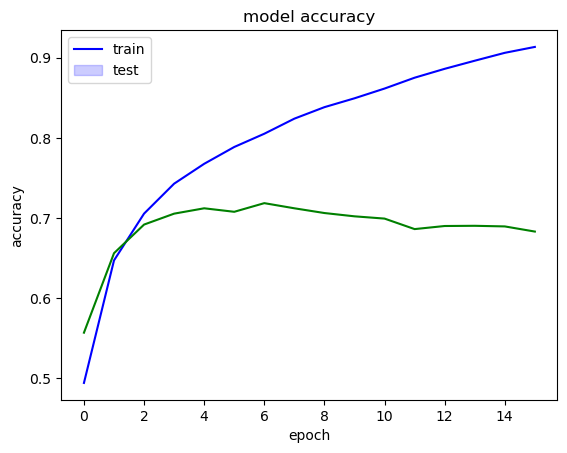

In [32]:
summarize_history(history_rnn)

#### Plot confusion matrix

305/305 [==============================] - 2s 7ms/step


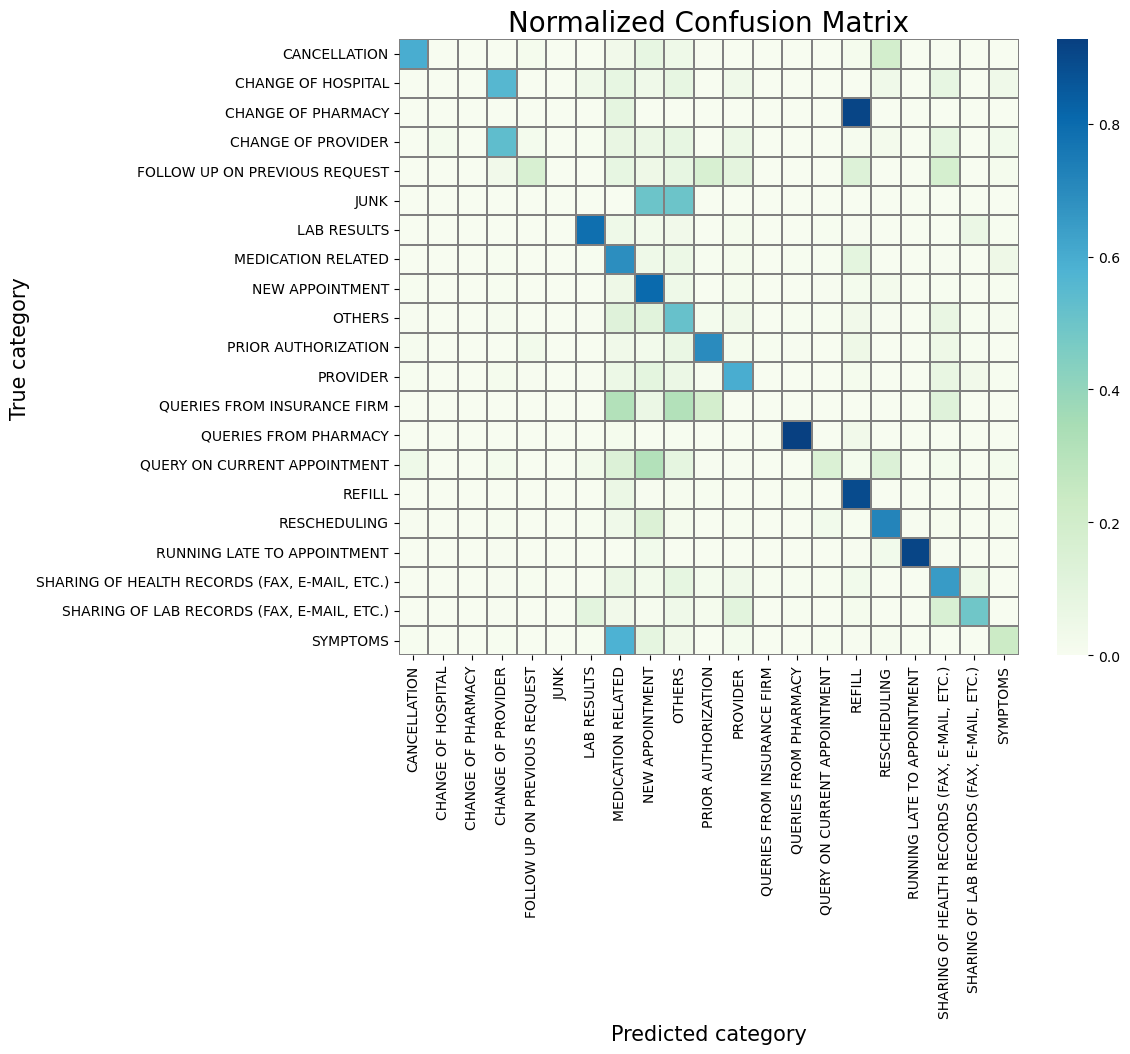

In [33]:
plot_confusion_matrix(model_rnn, transformed_test_data=X_test, test_target=df_y_test)

#### Inspect wrong predictions

In [34]:
print("Look at a few wrong predictions:")
# concat_prediction(model_rnn, 5)
concat_prediction(model_rnn, test_data=df_X_test, transformed_test_data=X_test, test_target=df_y_test)

Look at a few wrong predictions:
305/305 [==============================] - 2s 7ms/step
20061
pm brooke obrien sent date prioritize patient currently schedule auth need elig centricity pm brooke obrien kellee currie please obtain auth send schedule cerivical esi x lumbar esi x please make sure patient network benefit thanks
Actual label:NEW APPOINTMENT
Predicted label: OTHERS


11534
patient clld poctest result appointment patient patient state shed like spe md labtype result also plan care shed like know shed like know keep appointment please back advise back patient back speak rn regard labtype result plan care tinasia ingram lpn please advise thanks lisa gilligan rn tell lab normal good ask steroid help also ask often take excedrin patricia k naslund md also want know keep appointment timephrase lisa gilligan rn yes let see timephrase patricia k naslund md speak patient regard pkn instruction verbalize understanding
Actual label:LAB RESULTS
Predicted label: MEDICATION RELATED


3534

#### Multiple evaluation metrics

In [35]:
print(classification_report(df_y_test, generate_prediction(model_rnn, transformed_test_data=X_test)))

305/305 [==============================] - 2s 8ms/step
                                               precision    recall  f1-score   support

                                 CANCELLATION       0.61      0.59      0.60       111
                           CHANGE OF HOSPITAL       0.00      0.00      0.00        25
                           CHANGE OF PHARMACY       0.00      0.00      0.00        11
                           CHANGE OF PROVIDER       0.55      0.53      0.54       163
                FOLLOW UP ON PREVIOUS REQUEST       0.24      0.16      0.20        61
                                         JUNK       0.00      0.00      0.00         2
                                  LAB RESULTS       0.84      0.79      0.81       420
                           MEDICATION RELATED       0.66      0.69      0.68      1800
                              NEW APPOINTMENT       0.76      0.80      0.78      1730
                                       OTHERS       0.63      0.52      0.

/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### CNN

#### Train model

In [36]:
history_cnn = model_cnn.fit(X_train, y_train, \
                      batch_size=hparams["batch_size"],
                      epochs=hparams["epochs"],
                      verbose=1, \
                      validation_split=0.1)

score_cnn = model_cnn.evaluate(X_test, y_test, \
                        batch_size=hparams["batch_size"], verbose=1)
print('Test score:', score_cnn[0])
print('Test accuracy:', score_cnn[1])

Epoch 1/16
1095/1095 [==============================] - 16s 14ms/step - loss: 1.4882 - accuracy: 0.5491 - val_loss: 1.1701 - val_accuracy: 0.6246
Epoch 2/16
1095/1095 [==============================] - 4s 4ms/step - loss: 1.0518 - accuracy: 0.6709 - val_loss: 1.0347 - val_accuracy: 0.6610
Epoch 3/16
1095/1095 [==============================] - 2s 2ms/step - loss: 0.8953 - accuracy: 0.7127 - val_loss: 0.9668 - val_accuracy: 0.6872
Epoch 4/16
1095/1095 [==============================] - 2s 2ms/step - loss: 0.7833 - accuracy: 0.7455 - val_loss: 0.9473 - val_accuracy: 0.6947
Epoch 5/16
1095/1095 [==============================] - 2s 2ms/step - loss: 0.7080 - accuracy: 0.7671 - val_loss: 0.9744 - val_accuracy: 0.6898
Epoch 6/16
1095/1095 [==============================] - 2s 2ms/step - loss: 0.6390 - accuracy: 0.7886 - val_loss: 1.0003 - val_accuracy: 0.6939
Epoch 7/16
1095/1095 [==============================] - 2s 2ms/step - loss: 0.5821 - accuracy: 0.8042 - val_loss: 1.0224 - val_accurac

#### Visualize training history

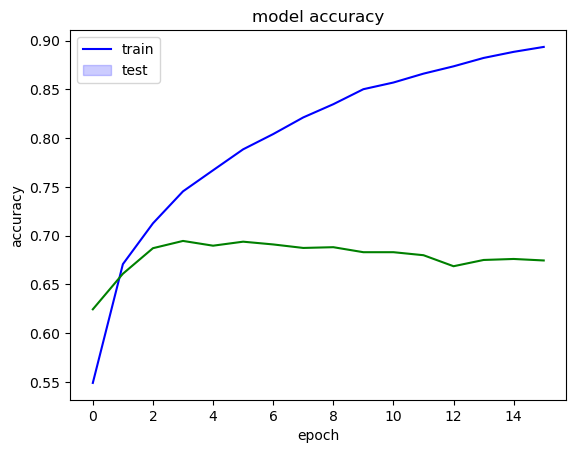

In [37]:
summarize_history(history_cnn)

#### Plot confusion matrix

305/305 [==============================] - 0s 421us/step


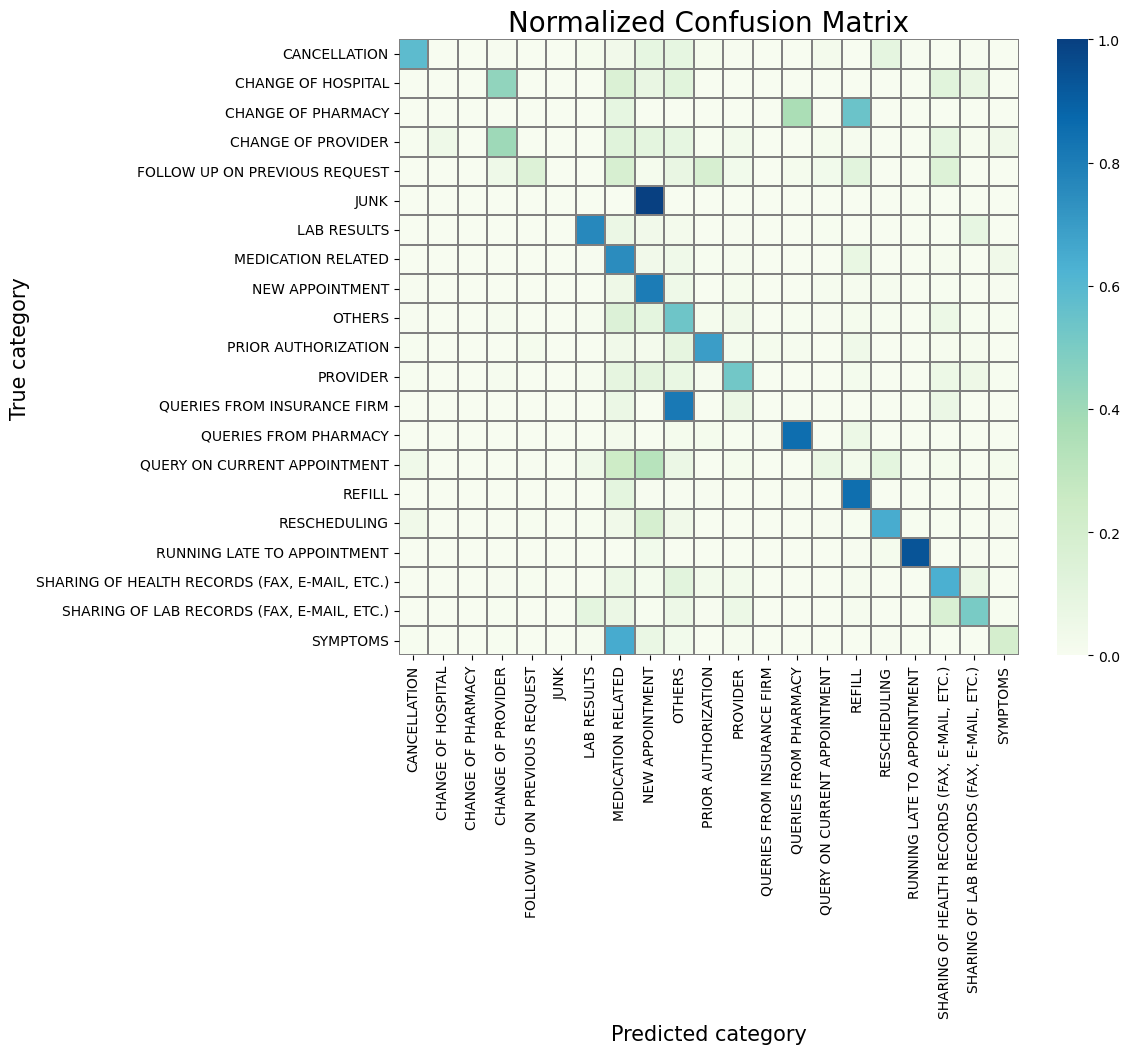

In [38]:
# plot_confusion_matrix(model_cnn)
plot_confusion_matrix(model_cnn, transformed_test_data=X_test, test_target=df_y_test)

#### Inspect wrong predictions

In [39]:
print("Look at a few wrong predictions:")
# concat_prediction(model_cnn, 5)
concat_prediction(model_cnn, test_data=df_X_test, transformed_test_data=X_test, test_target=df_y_test)

Look at a few wrong predictions:
305/305 [==============================] - 0s 444us/step
30187
patient rov timephrase take work fail patient patient rov timephrase take work fail get note please generate note employer timephrase patient want pick rna follow spoke beth tell would able give note blank date figure would need per patient let us know ashley arnold rn patient state hr dept find let know beth spell patient drop fmla paperwork put rio box beth spell
Actual label:SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Predicted label: OTHERS


45502
increased numbness foot name patient patient start lose feeling foot approximately wks ago usually happen gullian barre nothing occur time wonder need anything speak pt co recent increase foot tingling past week deny sx currently patient lov pkn schedule ov harry lay np timephrase patient agreeable phone complete lisa rowley rn
Actual label:MEDICATION RELATED
Predicted label: SYMPTOMS


47663
unable reach letter mail phone service kellee cur

#### Multiple evaluation metrics

In [40]:
print(classification_report(df_y_test, generate_prediction(model_cnn, transformed_test_data=X_test)))

305/305 [==============================] - 0s 436us/step
                                               precision    recall  f1-score   support

                                 CANCELLATION       0.56      0.59      0.57       111
                           CHANGE OF HOSPITAL       0.00      0.00      0.00        25
                           CHANGE OF PHARMACY       0.00      0.00      0.00        11
                           CHANGE OF PROVIDER       0.55      0.40      0.47       163
                FOLLOW UP ON PREVIOUS REQUEST       0.29      0.15      0.20        61
                                         JUNK       0.00      0.00      0.00         2
                                  LAB RESULTS       0.80      0.76      0.78       420
                           MEDICATION RELATED       0.62      0.75      0.68      1800
                              NEW APPOINTMENT       0.77      0.80      0.79      1730
                                       OTHERS       0.62      0.54      

/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### Hyperparameter optimization

RNN LSTM has marginally better accuracy than CNN, but CNN is much faster to train than RNN as it has fewer parameters. With this consideration, we perform hyperparameter optimization on our CNN model, hoping to improve its predictive performance. 

In [41]:
def model_builder(hp):
    model = models.Sequential()

    model.add(layers.Embedding(hparams["max_num_words"], hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))
    model.add(layers.Conv1D(activation="relu", filters=32, kernel_size=3, padding="same"))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.5)) # dropout after pooling
    model.add(layers.Flatten())
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
    
    return model

In [42]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=hparams["epochs"],
                     factor=3,
                     )

Reloading Tuner from ./untitled_project/tuner0.json


In [43]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#### Conclusion for hyperparameter tuning

In [14]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.001.



In [45]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/50
974/974 [==============================] - 16s 16ms/step - loss: 1.4866 - accuracy: 0.5488 - val_loss: 1.1534 - val_accuracy: 0.6352
Epoch 2/50
974/974 [==============================] - 4s 4ms/step - loss: 1.0049 - accuracy: 0.6834 - val_loss: 0.9843 - val_accuracy: 0.6870
Epoch 3/50
974/974 [==============================] - 3s 3ms/step - loss: 0.8405 - accuracy: 0.7287 - val_loss: 0.9546 - val_accuracy: 0.6965
Epoch 4/50
974/974 [==============================] - 3s 3ms/step - loss: 0.7325 - accuracy: 0.7592 - val_loss: 0.9796 - val_accuracy: 0.6908
Epoch 5/50
974/974 [==============================] - 2s 2ms/step - loss: 0.6414 - accuracy: 0.7858 - val_loss: 0.9847 - val_accuracy: 0.6963
Epoch 6/50
974/974 [==============================] - 2s 2ms/step - loss: 0.5720 - accuracy: 0.8081 - val_loss: 1.0367 - val_accuracy: 0.6873
Epoch 7/50
974/974 [==============================] - 2s 2ms/step - loss: 0.5118 - accuracy: 0.8272 - val_loss: 1.0594 - val_accuracy: 0.6963
Epoc

In [47]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

305/305 [==============================] - 0s 807us/step - loss: 0.9298 - accuracy: 0.7030
[test loss, test accuracy]: [0.9297992587089539, 0.7029997706413269]


#### Multiple evaluation metrics

In [48]:
print(classification_report(df_y_test, generate_prediction(hypermodel, transformed_test_data=X_test)))

305/305 [==============================] - 0s 464us/step
                                               precision    recall  f1-score   support

                                 CANCELLATION       0.61      0.31      0.41       111
                           CHANGE OF HOSPITAL       0.00      0.00      0.00        25
                           CHANGE OF PHARMACY       0.00      0.00      0.00        11
                           CHANGE OF PROVIDER       0.57      0.31      0.40       163
                FOLLOW UP ON PREVIOUS REQUEST       0.00      0.00      0.00        61
                                         JUNK       0.00      0.00      0.00         2
                                  LAB RESULTS       0.82      0.79      0.81       420
                           MEDICATION RELATED       0.64      0.79      0.71      1800
                              NEW APPOINTMENT       0.75      0.82      0.78      1730
                                       OTHERS       0.60      0.57      

/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lee/conda_envs/tensorflow2_13-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### Summary
| Algorithm | Accuracy (in test data) |
| --- | ----------- |
| MLP | 0.6434 |
| RNN | 0.6999 |
| CNN | 0.6932 |
| CNN with tuned hyperparameters | 0.7030 |

### Analysis

**What improved model performance**:
* Using RNN & CNN algorithms instead of MLP. **why**: These two algorithms are more suitable for NLP tasks as mentioned in the reasons for choosing these two architectures.
* Hyperparameter tuning

**What would not have improved performance**: Using more epochs in training. For all 3 models, I have plotted the relationship between the number of epochs and model accuracy. Their flat trajectory all show that training the model for more epochs is not likely to continue improve the model performance. 

**Troubleshooting**: Spot-checking the incorrect predictions, we notice some consistent patterns. For example, SYMPTOMS is often mispredicted as MEDICATION RELATED. In the original dataset, SYMPTOMS is a smaller subset than MEDICATION RELATED (about 1:9). More data in the smaller categories may help improve predictive performance.

## Discussion and conclusion

**Results**: The CNN model with optimized hyperparameters is my best performing model, with 0.7030 accuracy in test data.

**Learning and takeaways**
* RNN LSTM and CNN have similar performances; both perform more strongly than MLP. RNN LSTM performs marginally better in terms of overall accuracy before hyperparameter tuning. After tuning the hyperparameters of the CNN model, it has slightly better performance than RNN. 

**What will not work**
* Comparing the confusion matrices of these models, we see that they make correct predictions in approximately the same classes of target (LAB RESULTS through PROVIDER, QUERIES FROM PHARMACY through SYMPTOMS in the confusion matrices). Ensembling these models may not improve performance.

**Ways to improve**
* Building more complex CNN models by adding more convolutional layers.
* Tuning other hyperparameters, such as the convolutional layer's kernel size, stride, etc.
* Adding normalization layers.